In [912]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

In [913]:
data = pd.read_csv('train.csv')
data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [914]:
data.shape

(891, 12)

In [915]:
data['female'] = data['Sex'].apply(lambda x: 1 if x=='female' else 0)
data = data.drop('Sex',axis = 1)

## Dataset Cleaning

In [916]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected stage_dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [917]:
missing_values_table(data)

Your selected stage_dataframe has 12 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


In [918]:
data['cabin_rank'] = data['Cabin'].apply(lambda x: x if pd.isnull(x) else x[0])
data = data.drop('Cabin',axis = 1)
data['cabin_rank'].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [919]:
one_hot_cabin = pd.get_dummies(data['cabin_rank'],prefix='cabin')
data = data.join(one_hot_cabin)

In [920]:

has_cabin_boolean = data['cabin_rank'].apply(lambda x: 0 if pd.isnull(x) else 1)
data = data.assign(has_cabin = has_cabin_boolean)
data.has_cabin.describe()

count    891.000000
mean       0.228956
std        0.420397
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: has_cabin, dtype: float64

In [921]:
one_hot_embark = pd.get_dummies(data['Embarked'],prefix='from')
data = data.join(one_hot_embark)

In [922]:
N_from_C = sum(data['from_C'])
N_from_Q = sum(data['from_Q'])
N_from_S = sum(data['from_S'])

In [923]:
fill_null_embark = random.choices(
population=['from_C', 'from_Q', 'from_S'],
weights=[N_from_C/(N_from_C+N_from_Q+N_from_S), N_from_Q/(N_from_C+N_from_Q+N_from_S), N_from_S/(N_from_C+N_from_Q+N_from_S)],
k=2)

In [924]:
missing_embark_index = data[data['from_C']+data['from_Q']+data['from_S']==0].index.values

In [925]:
data.loc[missing_embark_index[0],fill_null_embark[0]]=1
data.loc[missing_embark_index[1],fill_null_embark[1]]=1

In [926]:
data['Age'] = data['Age'].apply(lambda x: 28.0 if pd.isnull(x) else x)

In [927]:
numerical_data = data.drop(['Name', 'PassengerId', 'Embarked','cabin_rank', 'Ticket'],axis = 1)
numerical_data = (numerical_data-numerical_data.min())/(numerical_data.max()-numerical_data.min())
numerical_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,female,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,has_cabin,from_C,from_Q,from_S
0,0.0,1.0,0.271174,0.125,0.0,0.014151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.472229,0.125,0.0,0.139136,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,1.0,0.321438,0.000,0.0,0.015469,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.434531,0.125,0.0,0.103644,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,0.434531,0.000,0.0,0.015713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Model Magic

In [928]:
x = numerical_data.iloc[:, 1:].values
y = numerical_data.iloc[:, :1].values

In [929]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4)

In [930]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

#### KNN

In [931]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train, y_train.ravel())

KNeighborsClassifier(n_neighbors=7)

In [932]:
y_pred_knn = knn.predict(x_test)

In [933]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85       223
         1.0       0.76      0.72      0.74       134

    accuracy                           0.81       357
   macro avg       0.80      0.79      0.80       357
weighted avg       0.81      0.81      0.81       357



In [934]:
results_knn = pd.crosstab(y_test.ravel(), y_pred_knn, rownames=['Actual'], colnames=['Predicted'], margins=True)
results_knn

Predicted,0.0,1.0,All
Actual,,,
0.0,192,31,223
1.0,37,97,134
All,229,128,357


In [935]:
print('Percent of TN (did not survive):', results_knn[0][0]/results_knn['All'][0]*100)
print('Percent of TP (survived):', results_knn[1][1]/results_knn['All'][1]*100)

Percent of TN (did not survive): 86.09865470852019
Percent of TP (survived): 72.38805970149254


#### Discriminant Analysis

In [936]:
lda = LinearDiscriminantAnalysis(n_components = 1)
lda.fit(x_train, y_train.ravel())

LinearDiscriminantAnalysis(n_components=1)

In [937]:
y_pred_lda = lda.predict(x_test)

In [938]:
print(classification_report(y_test, y_pred_lda))

              precision    recall  f1-score   support

         0.0       0.84      0.85      0.84       223
         1.0       0.75      0.72      0.73       134

    accuracy                           0.80       357
   macro avg       0.79      0.79      0.79       357
weighted avg       0.80      0.80      0.80       357



In [939]:
results_lda = pd.crosstab(y_test.ravel(), y_pred_lda, rownames=['Actual'], colnames=['Predicted'], margins=True)
results_lda

Predicted,0.0,1.0,All
Actual,,,
0.0,190,33,223
1.0,37,97,134
All,227,130,357


In [940]:
print('Percent of TN (did not survive):', results_lda[0][0]/results_lda['All'][0]*100)
print('Percent of TP (survived):', results_lda[1][1]/results_lda['All'][1]*100)

Percent of TN (did not survive): 85.20179372197309
Percent of TP (survived): 72.38805970149254


#### Logistic Regression

In [941]:
lr = LogisticRegression()
lr.fit(x_train, y_train.ravel())

LogisticRegression()

In [942]:
y_pred_lr = lr.predict(x_test)

In [943]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

         0.0       0.84      0.85      0.85       223
         1.0       0.74      0.74      0.74       134

    accuracy                           0.81       357
   macro avg       0.79      0.79      0.79       357
weighted avg       0.81      0.81      0.81       357



In [944]:
results_lr = pd.crosstab(y_test.ravel(), y_pred_lr, rownames=['Actual'], colnames=['Predicted'], margins=True)
results_lr

Predicted,0.0,1.0,All
Actual,,,
0.0,189,34,223
1.0,35,99,134
All,224,133,357


In [945]:
print('Percent of TN (did not survive):', results_lr[0][0]/results_lr['All'][0]*100)
print('Percent of TP (survived):', results_lr[1][1]/results_lr['All'][1]*100)

Percent of TN (did not survive): 84.75336322869956
Percent of TP (survived): 73.88059701492537


# Compare

In [946]:
print('Accuracy KNN: {:.2f}'.format(accuracy_score(y_test, y_pred_knn)))
print('Accuracy LDA: {:.2f}'.format(accuracy_score(y_test, y_pred_lda)))
print('Accuracy LR: {:.2f}'.format(accuracy_score(y_test, y_pred_lr)))

Accuracy KNN: 0.81
Accuracy LDA: 0.80
Accuracy LR: 0.81


In [947]:
print('Error Rate KNN: {:.2f}'.format(1 - accuracy_score(y_test, y_pred_knn)))
print('Error Rate LDA: {:.2f}'.format(1 - accuracy_score(y_test, y_pred_lda)))
print('Error Rate LR: {:.2f}'.format(1 - accuracy_score(y_test, y_pred_lr)))

Error Rate KNN: 0.19
Error Rate LDA: 0.20
Error Rate LR: 0.19


LR: 0.780922 (STD: 0.046272)
LDA: 0.779001 (STD: 0.044625)
KNN: 0.788225 (STD: 0.038452)


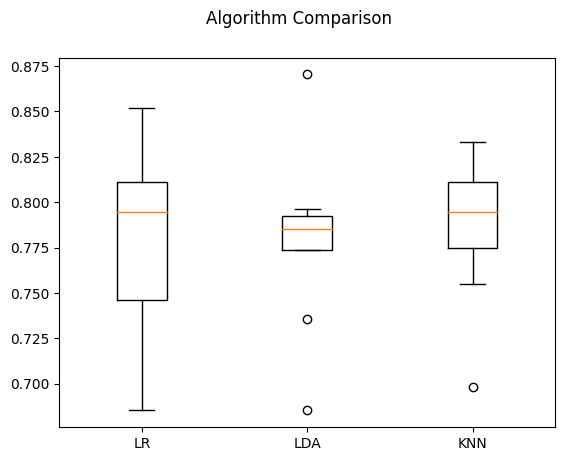

In [953]:
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10)
	cv_results = model_selection.cross_val_score(model, x_train, y_train.ravel(), cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (STD: %f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [949]:
def get_neighbors(xs, sample, k=5):
    neighbors = [(x, np.sum(np.abs(x - sample))) for x in xs]
    neighbors = sorted(neighbors, key=lambda x: x[1])
    return np.array([x for x, _ in neighbors[:k]])


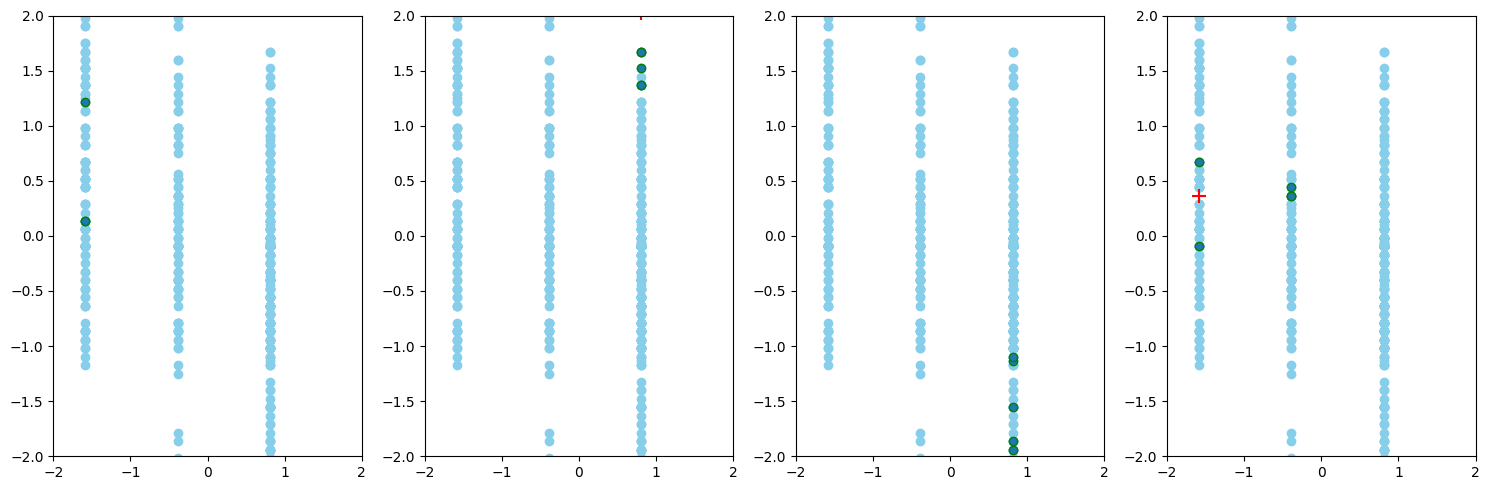

In [950]:

_, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
for i in range(4):
    sample = x_test[i]
    neighbors = get_neighbors(x_train, sample, k=5)
    ax[i].scatter(x_train[:, 0], x_train[:, 1], c="skyblue")
    ax[i].scatter(neighbors[:, 0], neighbors[:, 1], edgecolor="green")
    ax[i].scatter(sample[0], sample[1], marker="+", c="red", s=100)
    ax[i].set(xlim=(-2, 2), ylim=(-2, 2))

plt.tight_layout()

#### Most important variable

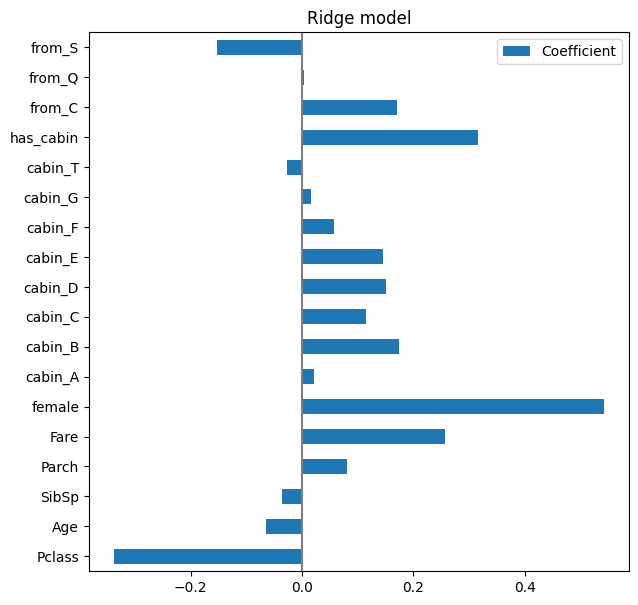

In [951]:
coefs = pd.DataFrame(numerical_data.corr()['Survived'][1:]).rename(columns={'Survived': 'Coefficient'})

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)


model score on training data: 0.8825194079511719
model score on testing data: 0.43574225233661823


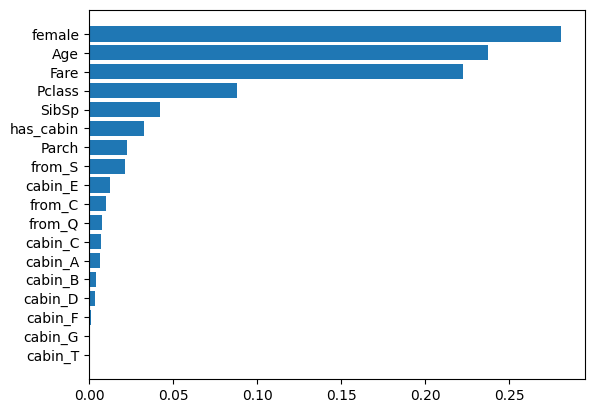

In [952]:
model = RandomForestRegressor()
model.fit(x_train, y_train.ravel())
print(f'model score on training data: {model.score(x_train, y_train)}')
print(f'model score on testing data: {model.score(x_test, y_test)}')

importances = model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(numerical_data.columns[1:])[indices])

#### Improvements
- possibly improve knn by determining optimal number of neighbors
- find out what exactly the variable detection thing does/if it is accurate
- compare actual algorithms used, don't repeat process
- do it with test data --> compare with submission from tutorial?